IMPORTING LIBRARIES

In [11]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
#LinearRegression is a machine learning library for linear regression

# pandas and numpy are used for data manipulation

# matplotlib and seaborn are used for plotting graphs
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data


reading the past 12 years of daily Gold ETF 

[*********************100%***********************]  1 of 1 completed


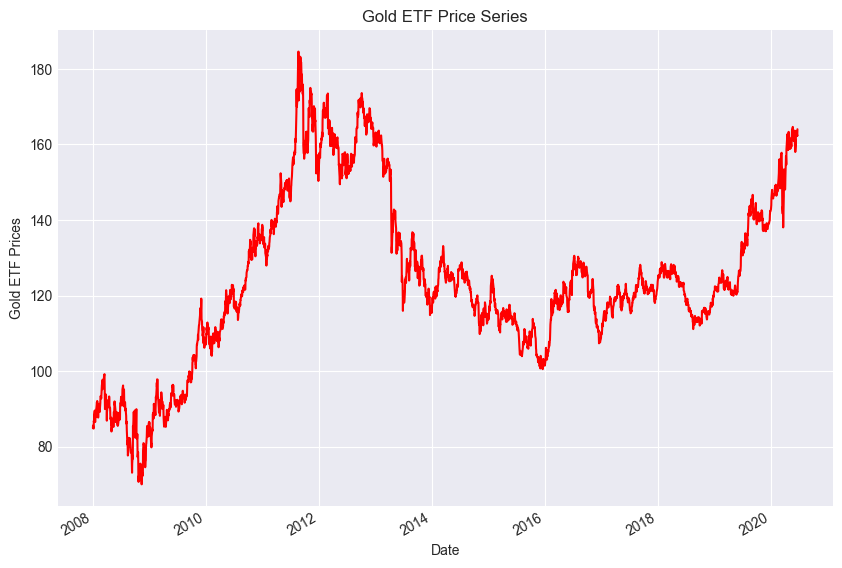

In [12]:
# Read data
Df = yf.download('GLD', '2008-01-01', '2020-6-22', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7), color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()


define dependent variables

In [13]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9']]

# Define dependent variable
y = Df['next_day_price']


split data in train and test

In [14]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]


Creating a linear regression model

In [15]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))


Linear Regression model
Gold ETF Price (y) = 1.20 * 3 Days Moving Average (x1) + -0.21 * 9 Days Moving Average (x2) + 0.43 (constant)


Predict the Gold ETF prices

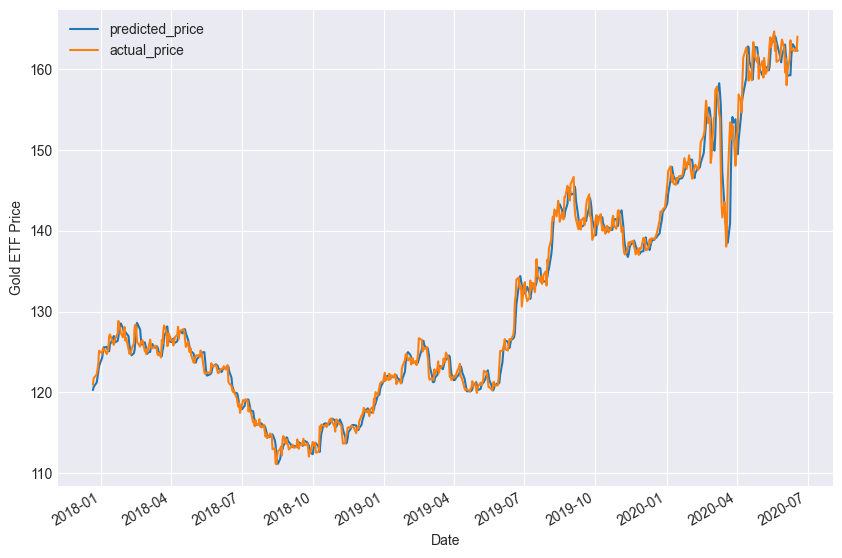

In [16]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()


goodness of the fit 

In [17]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))


98.85

Plotting cumulative returns

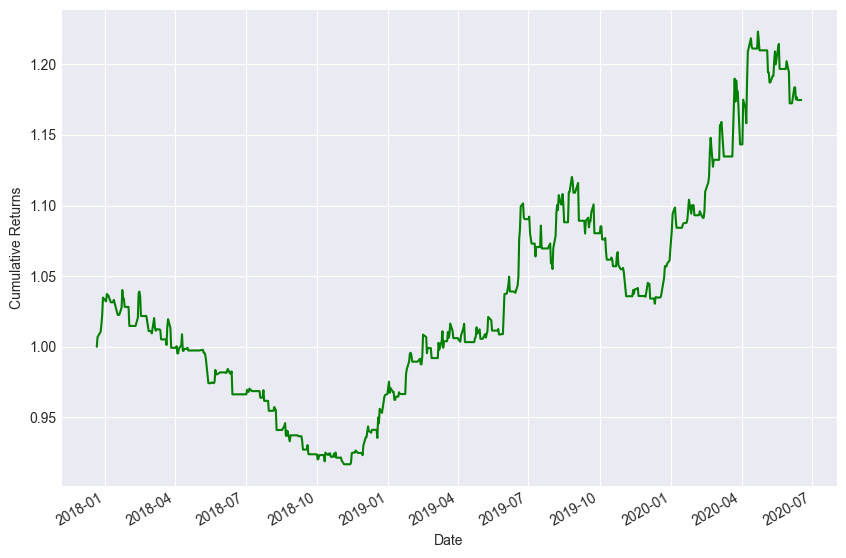

In [18]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(
    1) < gold.predicted_price_next_day, 1, 0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10, 7), color='g')
plt.ylabel('Cumulative Returns')
plt.show()


Sharpe ratio

In [19]:
# Calculate sharpe ratio
sharpe = gold['strategy_returns'].mean(
)/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)


'Sharpe Ratio 0.73'

the following predict the gold prices and give a trading signal whether we should buy GLD or take no position.

In [20]:
# import datetime and get today's date
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%***********************]  1 of 1 completed


C:\Users\KIIT\AppData\Local\Temp\ipykernel_11920\1356695606.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
C:\Users\KIIT\AppData\Local\Temp\ipykernel_11920\1356695606.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")


Date,2023-05-12
signal,No Position
predicted_gold_price,187.226183
